In [ ]:
# https://towardsdatascience.com/explain-your-model-with-the-shap-values-bc36aac4de3d

In [12]:
import pandas as pd
import numpy as np
import plotly
np.random.seed(0)
import matplotlib.pyplot as plt

## Sklearn ecosystem <3!
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.impute import IterativeImputer
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score


<AxesSubplot:>

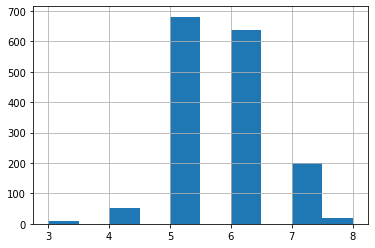

In [4]:

#################
# Load the data #
#################
df = pd.read_csv('/alloc/data/fury_fda-general-analysis/ML/winequality-red.csv') # ,sep=';')
df.shape
df.columns
df['quality'] = df['quality'].astype(int)
df['quality'].hist()



[0.02771784 0.14608857 0.0098873  0.03979135 0.03834853 0.02349039
 0.07114265 0.01940386 0.04327445 0.20548462 0.37537044]


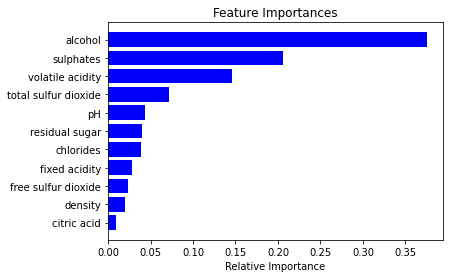

In [5]:
#################
#    Modeling   # 
#################
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor

Y = df['quality']
X =  df[['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol']]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2)

model = RandomForestRegressor(max_depth=6, random_state=0, n_estimators=10)
model.fit(X_train, Y_train)  


# Show the variable importance
print(model.feature_importances_)

importances = model.feature_importances_
indices = np.argsort(importances)

features = X_train.columns
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()


In [16]:
from sklearn import metrics
pred= np.round(model.predict(X_test),2)
gt=Y_test
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(gt, pred))
print('Mean Squared Error (MSE):', metrics.mean_squared_error(gt, pred))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(gt, pred)))
mape = np.mean(np.abs((gt - pred) / np.abs(gt)))
print('Mean Absolute Percentage Error (MAPE):', round(mape * 100, 2))
print('Accuracy:', round(100*(1 - mape), 2))

Mean Absolute Error (MAE): 0.47906250000000006
Mean Squared Error (MSE): 0.379471875
Root Mean Squared Error (RMSE): 0.6160128854171802
Mean Absolute Percentage Error (MAPE): 8.99
Accuracy: 91.01


## **Shapley value:** It is the average of the marginal contributions across all permutations. 

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


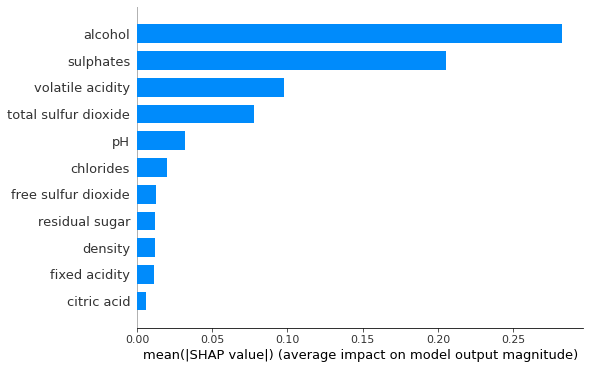

In [18]:

################
#  The SHAP    #
################
import shap
shap_values = shap.TreeExplainer(model).shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")


### The SHAP value plot can further show the positive and negative relationships of the predictors with the target variable

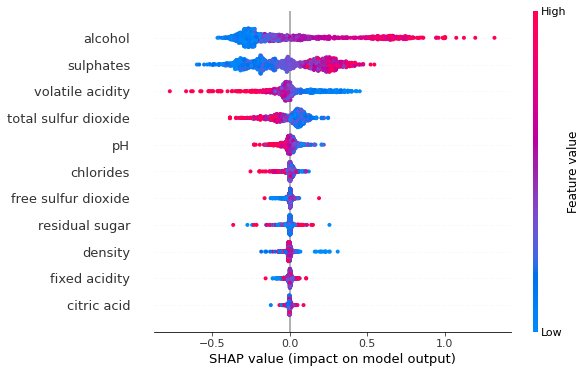

In [19]:
shap.summary_plot(shap_values, X_train)

* Feature importance: Variables are ranked in descending order.
* Impact: The horizontal location shows whether the effect of that value is associated with a higher or lower prediction.
* Original value: Color shows whether that variable is high (in red) or low (in blue) for that observation.
* Correlation: A high level of the “alcohol” content has a high and positive impact on the quality rating. The “high” comes from the red color, and the “positive” impact is shown on the X-axis. Similarly, we will say the “volatile acidity” is negatively correlated with the target variable.

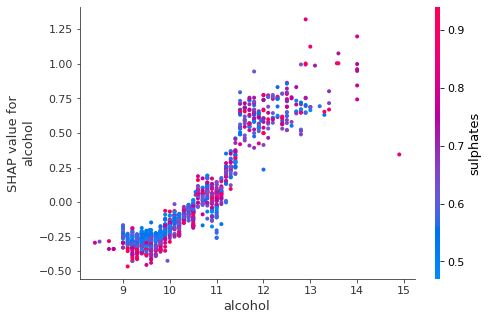

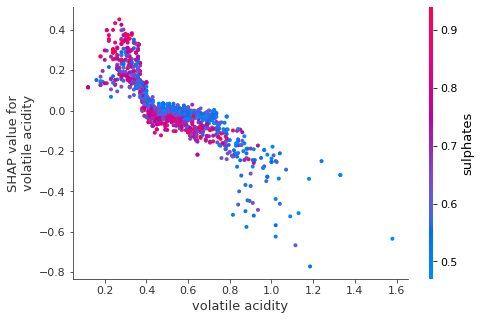

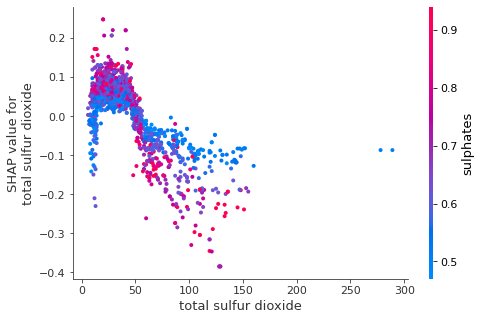

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


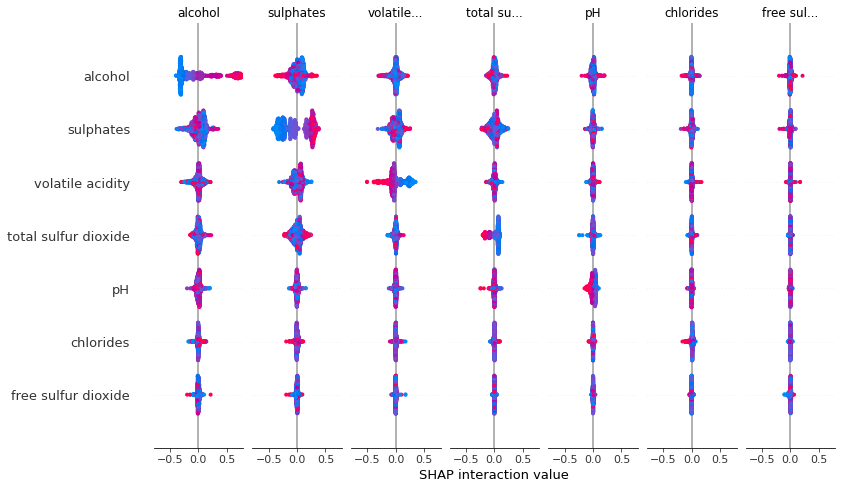

In [20]:


shap.dependence_plot("alcohol", shap_values, X_train)

shap.dependence_plot("volatile acidity", shap_values, X_train)

shap.dependence_plot("total sulfur dioxide", shap_values, X_train, show=False)
plt.show()

shap_interaction_values = shap.TreeExplainer(model).shap_interaction_values(X_train.iloc[:2000,:])

shap.summary_plot(shap_interaction_values, X_train.iloc[:2000,:])

X_output = X_test.copy()
X_output.loc[:,'predict'] = np.round(model.predict(X_output),2)


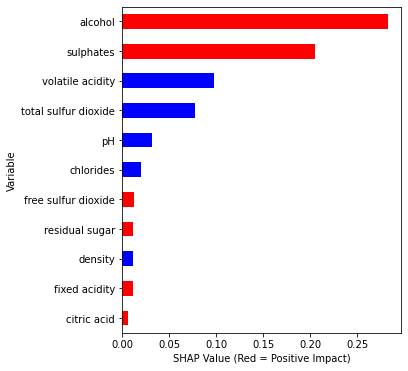

In [7]:
def ABS_SHAP(df_shap,df):
    #import matplotlib as plt
    # Make a copy of the input data
    shap_v = pd.DataFrame(df_shap)
    feature_list = df.columns
    shap_v.columns = feature_list
    df_v = df.copy().reset_index().drop('index',axis=1)
    
    # Determine the correlation in order to plot with different colors
    corr_list = list()
    for i in feature_list:
        b = np.corrcoef(shap_v[i],df_v[i])[1][0]
        corr_list.append(b)
    corr_df = pd.concat([pd.Series(feature_list),pd.Series(corr_list)],axis=1).fillna(0)
    # Make a data frame. Column 1 is the feature, and Column 2 is the correlation coefficient
    corr_df.columns  = ['Variable','Corr']
    corr_df['Sign'] = np.where(corr_df['Corr']>0,'red','blue')
    
    # Plot it
    shap_abs = np.abs(shap_v)
    k=pd.DataFrame(shap_abs.mean()).reset_index()
    k.columns = ['Variable','SHAP_abs']
    k2 = k.merge(corr_df,left_on = 'Variable',right_on='Variable',how='inner')
    k2 = k2.sort_values(by='SHAP_abs',ascending = True)
    colorlist = k2['Sign']
    ax = k2.plot.barh(x='Variable',y='SHAP_abs',color = colorlist, figsize=(5,6),legend=False)
    ax.set_xlabel("SHAP Value (Red = Positive Impact)")
    
ABS_SHAP(shap_values,X_train)


### The red color means a feature is positively correlated with the target variable. 

# some individual examples of the calculation

In [27]:
##################
# The force_plot #
##################
shap.initjs()

random_picks = np.arange(1,330,50)
S = X_output.iloc[random_picks]
S

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,predict
1032,8.1,0.820,0.00,4.1,0.095,5.0,14.0,0.99854,3.36,0.53,9.6,4.50
34,5.2,0.320,0.25,1.8,0.103,13.0,50.0,0.99570,3.38,0.55,9.2,5.35
1508,7.1,0.270,0.60,2.1,0.074,17.0,25.0,0.99814,3.38,0.72,10.6,6.26
1479,8.2,0.280,0.60,3.0,0.104,10.0,22.0,0.99828,3.39,0.68,10.6,5.93
866,6.8,0.490,0.22,2.3,0.071,13.0,24.0,0.99438,3.41,0.83,11.3,6.33
1519,6.6,0.700,0.08,2.6,0.106,14.0,27.0,0.99665,3.44,0.58,10.2,5.47
1193,6.4,0.885,0.00,2.3,0.166,6.0,12.0,0.99551,3.56,0.51,10.8,4.51


In [32]:
def shap_plot(j):
    explainerModel = shap.TreeExplainer(model)
    shap_values_Model = explainerModel.shap_values(S)
    p = shap.force_plot(explainerModel.expected_value, shap_values_Model[j], S.iloc[[j]])
    return(p)

X_train.mean()

Y_test.mean()


5.59375

In [25]:
# first row of X_output
shap_plot(0)


In [26]:
# 2nd row of X_output
shap_plot(1)

In [28]:
# 3th row
shap_plot(2)

In [29]:
# 4th row
shap_plot(3)

In [30]:
fig = shap_plot(4) 
fig

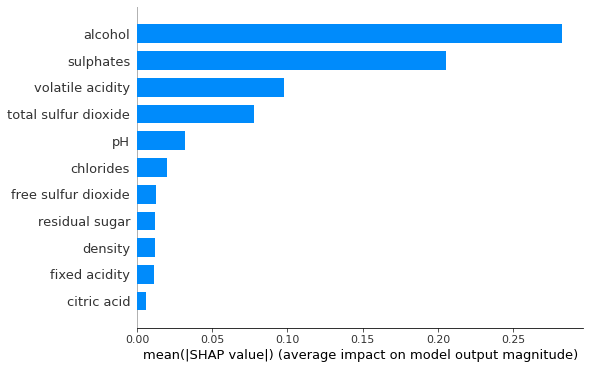

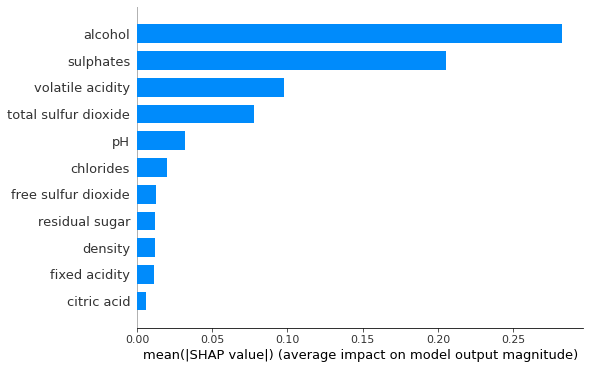

In [31]:
import matplotlib.pyplot as plt
f = plt.figure()
shap.summary_plot(shap_values, X_train, plot_type="bar")
f.savefig("/SHAP_plot.png", bbox_inches='tight', dpi=600)

fig = shap.summary_plot(shap_values, X_train, plot_type="bar")